## Racetrack with Monte Carlo Off-policy control

In this lab, we will implement the algorithm shown on p.111 of the textbook–Off Policy MC Control, for estimating $\pi^*$. Below is the problem as shown in the textbook:

* Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, -1, or 0 in each step, for a total of nine (3 x 3) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

To complete this exercise, we first recognize that there are three parts involved:
1. Setting up the environment
2. Creating the car agent capable of MC control
3. Train the agent and visualize outcome

### Setting Up the Environment

We want to create a grid with a defined area that is our racetrack. We also want to define areas where the start and finish lines are. Anytime when the car agent is out of bound, it is returned to a random position in the start line and the episode continues. 

Below shows a skeleton of a track that is made to model one of the tracks shown in figure 5.5 in the textbook. There are a couple of options in terms of setting up the environment. You may choose to complete the Track class by filling in the functions intentionally left blank, you could toss the template code and build a track environment to your own likings, or you could use the track environment provided by the ```gym``` Python module. 

Note that you will have to install ```gym``` and import it to this lab if you choose to use ```gym```, and you will need to integrate the control algorithm we are building in this lab with the environment.


#### Task 1: Complete the functions in the Track class


The ```Track``` class is equipped with some basic functions such as setting up and visualizing a track. The learning agent can interact with the track to obtain information like: 
    * the state of the cell it is in
        * the states are 'track', 'oob', 'start', 'finish'
    * a random coordinate for a start state
        * every time the agent goes off track, it will need to return to a randomized position on the starting line
    * any other functions you feel would make sense as part of the environment (e.g. if the agent has crossed the finish line or not)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [2]:
class Track:
    
  def __init__(self, _h, _w):
    self.w = _w
    self.h = _h
    # set each cell in grid as 'track'
    self.grid = np.array([['track'] * _w for _ in range(_h)], dtype='U8')

  def make_track_1(self):
    """
    sets the track on the left in figure 5.5 in textbook
    """
    # set start line
    self.grid[-1,:] = 'start'
    # set finish line
    self.grid[:,-1] = 'finish'
    # set area to be out of bound
    self.grid[:,0] = 'oob'
    self.grid[0, :] = 'oob'
    self.grid[:5,1] = 'oob'
    self.grid[:4,2] = 'oob'
    self.grid[:2,3] = 'oob'
    self.grid[-18:,1] = 'oob'
    self.grid[-10:,2] = 'oob'
    self.grid[-7:,3] = 'oob'
    self.grid[7:,11:] = 'oob'
    self.grid[8:,10] = 'oob'
    
    # so that row 0 is start line
    self.grid = np.flip(self.grid, axis=0)
    
  def show_grid(self, _show_trajectory=False, _ys=[], _xs=[]):
    """
    visualize the track with cells in  
    colors that coresponse to the cell type
    """
    flipped_grid = np.flip(self.grid, axis=0)
    # setting up the colors that goes with cell type
    self.color_dict = {'track': 'white', 
                       'oob': 'silver', 
                       'start': 'red', 
                       'finish': 'green'}
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 10)
    ax.set_xlim(-1/(self.w), self.w+1/(self.w))
    ax.set_ylim(-1/(self.h), self.h+1/(self.h))
    ax.set_axis_off()
    # use the table and cell objects to make grid
    table = Table(ax)
    # table = Table(ax, bbox=[0, 0, 1, 1])
    for (i, j), cell in np.ndenumerate(self.grid):
        table.add_cell(
            i, j, 1/self.w, 1/self.h, fill=True, 
            facecolor=self.color_dict[flipped_grid[i][j]]
        )
    ax.add_table(table)
    if _show_trajectory:
        xs = _xs + 0.5
        ys = _ys + 0.5
        plt.plot(xs, ys, '-')
    plt.show()
    
  def get_cell_state(self, _y, _x):
    """
    returns the state of the cell [_y, _x]
            ('track', 'oob', 'start', 'finish')
    """
    if _y < 0 or _y >= self.h or _x < 0 or _x >= self.w: 
        if self.h > _y > self.h-8 and _x >= self.w: 
            return 'finish'
        return 'oob'
    return self.grid[_y, _x]
    
    
  def randomized_start(self):
    """
    this function makes the assumption that 
    the start line will always be on the bottom row
    ---
    returns a tuple that represents a randomized 
            position on the start line
    """
    state = 'oob'
    while state != 'start':
        rand_i = np.random.randint(self.w)
        state = self.grid[0, rand_i]
    return np.array([0, rand_i]), np.array([0, 0])


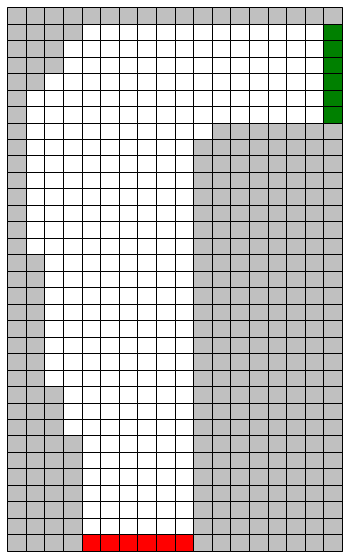

In [3]:
# Let's take a look at our environment
H = 33
W = 18
track = Track(H, W)
track.make_track_1()
track.show_grid()

### Creating the Car Agent

We want to give the car agent access to neccessary information such as:
* Its position on the grid
* Its velocity
* The availble actions and their constraints 
    * actions are +1, -1, and 0 in each direction on each step
        * this translates to 9 actions: $[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, -1]$
        * determine the dimension of the state space and state-action space so that the matrices for Q, C, pi, etc are implemented correctly
    * velocity components must be nonnegative and less than 5, and annot both be zero except at the starting line
        * how would you handle checking the bound?
        * if you had to correct the velocity because of the agent's action, do you record the action that was actually choosen or record the corrected action as if the agent knew about the constraint on its velocity? 

### Implementing the Learning Algorithm

We can also implement off-policy Monte Carlo control algorithm in this next code block. For Monte Carlo, we want to document for each episode, for each time step $t$ the state $S_t$, the action taken $A_t$, and the reward the eagent received after transitioning to the next state $R_{t+1}$. We will only update $Q$ after the agent reaches the terminal state, in our case, the finish line.

Since we want to implement an off-policy version of Monte Carlo, we also want to set up a policy matrix $\pi$ so that we can iterate on it based on the learning from finishing each episode. Note that the agent will not be following $\pi$ during the episode, and will instead follow a behavioral policy $b$, which is set to be any soft-policy in the textbook. Soft-policies can provide _coverage_, a property meaning that any actions taken under $\pi$ will be taken under $b$ with a non-zero probability. 

Below is a template for the ```Agent``` class with a couple of suggested functions. Feel free to complete the functions, or write other functions to complete the neccessary structures for the learning process.

#### Task 2: Complete the functions in the Agent class

In [4]:
class Agent:
    
    def __init__(self, _env, _eps=0.01, _gamma=0.9):
        
        self.env = _env
        
        # hyperparameters
        self.eps = _eps
        self.gamma = _gamma
        
        # agent's position: [y, x]
        self.pos = np.array([0, 0])
        self.cell_state = 'start'
        # agent's velocity: [velocity along y-axis, velocity along x-axis]
        self.v = np.array([0, 0])
        
        # 9 actions available
        self.actions = np.array([[i, j] for j in range(-1, 2) for i in range(-1, 2)])
        # set limits on velocity
        self.min_v = 1
        self.max_v = 4
        # state-action space dim
        self.q_dim = (self.env.h, self.env.w, self.max_v, self.max_v, len(self.actions))
        self.s_dim = (self.env.h, self.env.w, self.max_v, self.max_v)
        # Q is a 3D array
        self.q = np.full(self.q_dim, -1000) # arbitrary initialization value
                                              # another arbitrary initialization: np.random.rand()*(1/len(self.actions))
        # record keeping
        self.c = np.zeros(self.q_dim) # used to track cummulative reward
        self.r_rec = [] # keep a record of rewards
        self.s_rec = [] # keep a record of visited positions
        self.a_rec = [] # keep a record of actions taken
        
        # initialize a policy b
        self.pi = self.generate_policy()
        
    
    def clear_records(self):
        """
        resets data structures at the beginning of an episode
        """
        self.pos, self.v = self.env.randomized_start()
        self.cell_state = 'start'
        self.r_rec = [] 
        self.s_rec = [] 
        self.a_rec = []
    
    def generate_policy(self):
        """
        generate pi based on Q
        """
        pi = np.full(self.s_dim, -1)
        for y in range(self.env.h):
            for x in range(self.env.w):
                for vy in range(self.max_v):
                    for vx in range(self.max_v):
                        pi[y, x, vy, vx] = self.get_argmax(
                            self.q[y, x, vy, vx])
        return pi
    
    def get_argmax(self, _qs):
        """
        implement argmax for determining pi 
        ---
        returns the action with maximum expected value
        """
        max_as = np.where(_qs == _qs.max())[0]
        
        # below shows a solution where ties are broken randomly
        # instead of breaking ties consistantly
        return max_as[np.random.randint(len(max_as))]
        
        
    
    def find_possible_actions(self, _v):
        """
        gather actions that will not cause velocity  
        to be more than 4, or negative, or both zeros
        """
        possible_actions = []
        for a_i in range(len(self.actions)):
            new_v = _v + self.actions[a_i]
            if new_v.any() and (new_v < 5).all() and (new_v >= 0).all():
                possible_actions.append(a_i)
        return np.array(possible_actions, dtype=int)
        
    
    def epsilon_greedy(self):
        """
        implement a soft behavioral policy b 
        using epsilon-greedy
        ---
        returns an action
        """
        possible_actions = self.find_possible_actions(self.v)
        if np.random.rand() >= self.eps:
            qs = self.q[self.pos[0], self.pos[1], 
                        self.v[0]-1, self.v[1]-1]
            qs = qs[possible_actions]
            return possible_actions[self.get_argmax(qs)]
        else:
            a_i = np.random.randint(len(possible_actions))
            return possible_actions[a_i]
    
    
    def get_softmax(self, _y, _x, _vy, _vx):
        """
        implement a soft behavioral policy b 
        ---
        returns the action the agent is taking
        """
        # using softmax as the soft behavioral policy b
        softmax = np.exp(self.q[_y][_x][_vy][_vx])
        softmax /= np.sum(softmax)
        return softmax
    
    
    def get_next_pos(self):
        """
        accepts an action that is a np array [y, x]
        set the new position with the velocity
        """
        return self.pos + self.v
    
                                
    def get_new_v(self, _v, _action):
        """
        get new velocity from  
        current velocity and the choosen action
        """
        return _v + _action
    
                                
    def mc_step(self):
        """
        handles everything that needs to happen and store
        in a single time step for Monte Carlo control
        """
        # store position of agent
        self.s_rec.append([self.pos[0], self.pos[1], 
                      self.v[0]-1, self.v[1]-1])
        a_index = self.epsilon_greedy()            
        
        # store action of choice before uncertainty is introduced
        self.a_rec.append([a_index])
        
        # with probability 0.1 at each time step the velocity increments 
        # are both zero, independently of the intended increments.
        if np.random.rand() < 0.0: a_index = 4
        
        # get new velocity and position
        self.v = self.get_new_v(self.v, self.actions[a_index])
        self.pos = self.get_next_pos()
        
        # get the cell state of new position    
        self.cell_state = self.env.get_cell_state(self.pos[0], self.pos[1])
        
        # retrieve and store reward
        r = -1 if self.cell_state != 'finish' else 0
        self.r_rec.append(r)
                                
        # handle out of bound                        
        if self.cell_state == 'oob':
            self.pos, self.v = self.env.randomized_start()
        
    
    def offpolicy_mc_control(self, _episode=1000):
        """
        generates episodes and iteratively updates policy 
        """
        t_avg = 0
        for episode in range(_episode):
            t = 0
            self.clear_records()
            while self.cell_state != 'finish':
                self.mc_step()
                t += 1
                t_avg += 1
            if t <= 10:
                s_rec_np = np.array(self.s_rec)        
                self.env.show_grid(_show_trajectory=True, 
                                   _ys=s_rec_np[:,0], 
                                   _xs=s_rec_np[:,1])
            if episode % 10000 == 0 and episode != 0:
                print(f'episode {episode-10000}-{episode} reached terminal at t: {t_avg/10000}')
                t_avg = 0
                
            G = 0
            W = 1
            for t in reversed(range(len(self.r_rec)-1)):
                G = self.gamma * G + (self.r_rec[t+1])
                s_t = self.s_rec[t]
                a_t = self.a_rec[t]
                # increment c for state-action pair    
                self.c[tuple(s_t + a_t)] += W
                # make update to the expected value of state-action pair    
                c_t = self.c[tuple(s_t + a_t)]
                q_t = self.q[tuple(s_t + a_t)]
                update_t = (W / c_t) * (G - q_t)
                self.q[tuple(s_t + a_t)] += update_t
                
                # calculate b(A_t|S_t)
                b_as = self.eps / len(self.actions)
                if a_t[0] == self.pi[tuple(s_t)]:
                    b_as += (1 - self.eps)
                # pick max value from self.q[tuple(s_t)] to update policy
                self.pi[tuple(s_t)] = self.get_argmax(self.q[tuple(s_t)])
                # break loop conditionally
                if a_t[0] != self.pi[tuple(s_t)]: break
                # update W
                W /= b_as

        s_rec_np = np.array(self.s_rec)        
        self.env.show_grid(_show_trajectory=True, 
                           _ys=s_rec_np[:,0], 
                           _xs=s_rec_np[:,1])


## Traning with Monte Carlo

Now that you have set up the agent and the environment, train the agent. Play around with the hyperparameters and the number of episode to see how they impact performance.

You can visualize the agent's trajectory by using the ```show_grid()``` function provided in the ```Track``` class. Set the parameter ```_show_trajectory``` to ```True```, and pass in the y components and the x components of the agent's position history with the parameters ```_ys``` and ```_xs```.

There might be a lot of bugs in your code at first. A good benchmark is that the first episode typically takes about 1000-2000 time steps to complete, and the subsequent episode should take significantly less time steps to complete. 

episode 0-10000 reached terminal at t: 19.3303
episode 10000-20000 reached terminal at t: 17.8635
episode 20000-30000 reached terminal at t: 18.2624
episode 30000-40000 reached terminal at t: 18.0085
episode 40000-50000 reached terminal at t: 17.9627
episode 50000-60000 reached terminal at t: 17.9224
episode 60000-70000 reached terminal at t: 18.2701
episode 70000-80000 reached terminal at t: 17.8575
episode 80000-90000 reached terminal at t: 18.4229
episode 90000-100000 reached terminal at t: 17.7576
episode 100000-110000 reached terminal at t: 18.8477
episode 110000-120000 reached terminal at t: 18.426
episode 120000-130000 reached terminal at t: 17.8509
episode 130000-140000 reached terminal at t: 18.0552
episode 140000-150000 reached terminal at t: 17.7695
episode 150000-160000 reached terminal at t: 19.2433
episode 160000-170000 reached terminal at t: 19.9244
episode 170000-180000 reached terminal at t: 20.9559
episode 180000-190000 reached terminal at t: 19.956
episode 190000-200

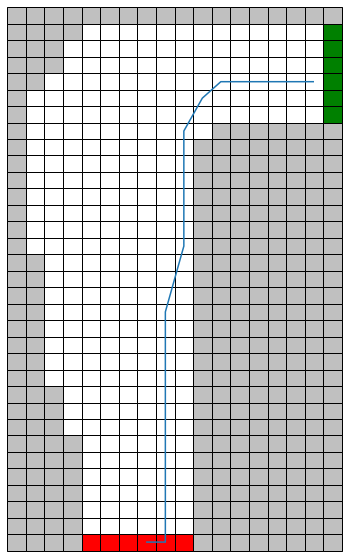

In [7]:
agent = Agent(track, _eps=0.006, _gamma=0.99)
agent.offpolicy_mc_control(_episode=1000000)